# Federal Reserve Minutes Sentiment Analysis 

The objective of this notebook is to extract topics and sentiment from Federal Minutes (2004-Present), leveraging natural language techniques such as bag of words and Latent Dirichlet Allocation (LDA). Sentiment is calculated using FinBert

Please use NBviewer for rendering if plotly graphs do not appear (via http://nbviewer.jupyter.org/github/JonnyFLDN/Federal-Reserve-Minutes-Topic-and-Sentiment-Modelling/blob/master/Topic%20%26%20Sentiment%20Analysis.ipynb)

# <a name="data-o"></a> Data Overview
Data was web scrapped using [Webscraper.py](https://github.com/JonnyFLDN/Federal-Reserve-Minutes-Topic-and-Sentiment-Modelling/blob/master/Minutes_Webscraper.py) from https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm and saved in the directory below. 
The year 2004 was chosen as the start-year given the acceleration of release dates to 3 weeks, and improved clarity in explanations of committee’s decisions and views [(Danker,2005)](https://www.federalreserve.gov/pubs/bulletin/2005/spring05_fomc.pdf)

<br> 
In this section we will examine the transcripts' structure.

## <a name="sum"></a>Summary

In [1]:
pip_packages = [
    "charset-normalizer==2.0.10",
    "cycler==0.11.0",
    "filelock==3.4.2",
    "flake8==4.0.1",
    "fonttools==4.29.0",
    "funcy==1.17",
    "future==0.18.2",
    "gensim==4.1.2",
    "huggingface-hub==0.4.0",
    "idna==3.3",
    "jinja2==3.0.3",
    "joblib==1.1.0",
    "kiwisolver==1.3.2",
    "markupsafe==2.0.1",
    "matplotlib==3.5.1",
    "mccabe==0.6.1",
    "nltk==3.6.7",
    "numexpr==2.8.1",
    "numpy==1.22.1",
    "packaging==21.3",
    "pandas==1.4.0",
    "pep8==1.7.1",
    "pillow==9.0.0",
    "pycodestyle==2.8.0",
    "pyflakes==2.4.0",
    "pyldavis==3.3.1",
    "pyparsing==3.0.7",
    "pytz==2021.3",
    "pyyaml==6.0",
    "regex==2022.1.18",
    "requests==2.27.1",
    "sacremoses==0.0.47",
    "scikit-learn==1.0.2",
    "scipy==1.7.3",
    "seaborn==0.11.2",
    "sklearn==0.0",
    "smart-open==5.2.1",
    "threadpoolctl==3.0.0",
    "tokenizers==0.11.4",
    "torch==1.10.2",
    "tqdm==4.62.3",
    "transformers==4.16.1",
    "urllib3==1.26.8"
]

# Generate pip install commands
for package in pip_packages:
    print(f"pip install {package}")


pip install charset-normalizer==2.0.10
pip install cycler==0.11.0
pip install filelock==3.4.2
pip install flake8==4.0.1
pip install fonttools==4.29.0
pip install funcy==1.17
pip install future==0.18.2
pip install gensim==4.1.2
pip install huggingface-hub==0.4.0
pip install idna==3.3
pip install jinja2==3.0.3
pip install joblib==1.1.0
pip install kiwisolver==1.3.2
pip install markupsafe==2.0.1
pip install matplotlib==3.5.1
pip install mccabe==0.6.1
pip install nltk==3.6.7
pip install numexpr==2.8.1
pip install numpy==1.22.1
pip install packaging==21.3
pip install pandas==1.4.0
pip install pep8==1.7.1
pip install pillow==9.0.0
pip install pycodestyle==2.8.0
pip install pyflakes==2.4.0
pip install pyldavis==3.3.1
pip install pyparsing==3.0.7
pip install pytz==2021.3
pip install pyyaml==6.0
pip install regex==2022.1.18
pip install requests==2.27.1
pip install sacremoses==0.0.47
pip install scikit-learn==1.0.2
pip install scipy==1.7.3
pip install seaborn==0.11.2
pip install sklearn==0.0
pip

In [2]:
import os
import pandas as pd
import numpy as np 
import re
import string

from utils.corpusutils import CorpusPreProcess, Document, Corpus
from utils.featureutils import FeatureProcessor,find_closest


from nltk.tokenize import WordPunctTokenizer
from nltk.data import LazyLoader
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from transformers import AutoTokenizer, AutoModelForSequenceClassification

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import jensenshannon
import torch
import joblib
import pickle
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()
import warnings
warnings.filterwarnings('ignore')

In [3]:

current_directory = os.getcwd()
root = os.path.join(current_directory,"Minutes")
word_tokenizer = WordPunctTokenizer()
sent_tokenizer = LazyLoader("tokenizers/punkt/english.pickle")
category_pattern = r'(\d{4})/*'
file_extension = r'*.txt'
file_pattern = r'(\d{8})/*'
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english') + list(string.punctuation) + ['u','.','s','--','-','."',',"','.)',')-','".','—','),'] 


fed_mins = CorpusPreProcess(root=root,file_extension = file_extension,
                            category_pattern=category_pattern,
                            file_pattern=file_pattern,
                            word_tokenizer = word_tokenizer,
                            sent_tokenizer=sent_tokenizer,
                            stemmer = stemmer,
                            lemmatizer = lemmatizer,
                            stop_words = stop_words
                            )

In [4]:
fed_mins_ids = fed_mins.get_file_ids()

print('Total number of files: '+str(len(fed_mins_ids)))
print('Number of paragraphs: '+str(len(fed_mins.get_paras())))
print('Number of sentences: '+str(len(fed_mins.get_sents())))
print('Number of words: '+str(len(fed_mins.get_words())))
print('\n'+'First file: '+ fed_mins_ids[0])
print('Last file: '+ fed_mins_ids[-1])

Total number of files: 143
Number of paragraphs: 17241
Number of sentences: 45009
Number of words: 1238889

First file: 20040128
Last file: 20211215


In [5]:
#For each Category
para_by_year = {}

for cat in fed_mins.get_category_ids():
    files = fed_mins.get_file_ids(category_id=cat)
    para_by_year[cat] = {'nparas':sum(len(fed_mins.get_paras(file_id=f)) for f in files)/len(files),
                        'nwords':sum(len(fed_mins.get_words(file_id=f)) for f in files)/len(files)}


<Axes: title={'center': 'Paragraphs and words overtime'}>

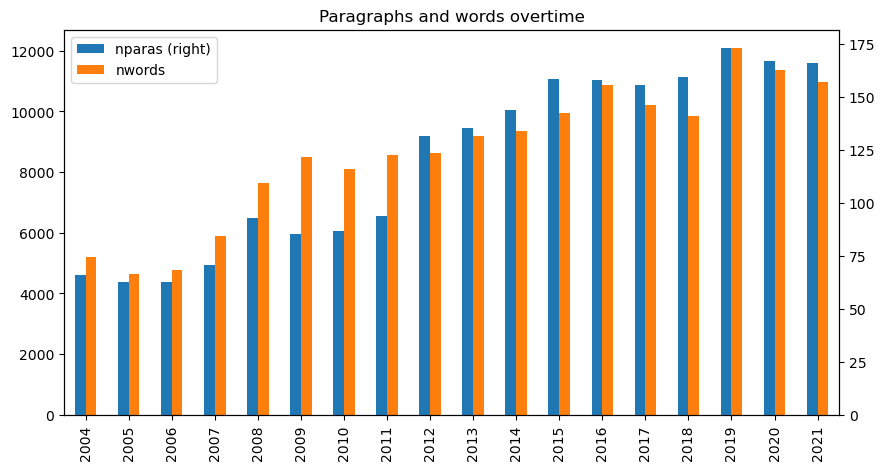

In [6]:
pd.DataFrame.from_dict(para_by_year).T.sort_index().plot(kind='bar',secondary_y='nparas',figsize=(10,5),title='Paragraphs and words overtime')


We can see an acceleration in the amount of paragraphs and words overtime.

In [7]:
start_regex = r"""(?i)(staff\sreview\sof\sthe\seconomic|the\sinformation\s[\s]?(?:reviewed|received|provided)|the\scommittee\sthen\sturned\sto\sa\sdiscussion\sof\sthe\seconomic\soutlook|in\sthe\scommittee[\']?s\sdiscussion\sof\scurrent\sand\sprospective\seconomic)"""
end_regex = r"""(?i)(at\sthe\sconclusion\sof\s[\s]?(?:the|this)\s(?:discussion|meetings)|the\scommitte\svoted\sto\sauthorize|the\svote\sencompassed\sapproval\sof)"""
file_stats = fed_mins.truncate_text(start_regex,end_regex,return_stats=True)

Overwritting existing folder


In [8]:
pd.Series(file_stats).rename('size_pct_change').to_frame().sort_values(by='size_pct_change')

size_pct_change
20200129.txt       -60.414296
20190130.txt       -59.268669
20180131.txt       -58.432987
20140129.txt       -57.307791
20050202.txt       -56.184258
...                       ...
20060629.txt       -14.868293
20060328.txt       -14.413643
20051101.txt       -14.146784
20061212.txt       -13.915782
20050322.txt       -13.067824

[143 rows x 1 columns]

At most files reduced by 60%

# Further pre-processing

In [9]:
file_example = '20171213'
sent_example = fed_mins.get_sents(file_id=file_example,stem=True,lemmatize=True)[32]
print('\033[1m'+"Example Sentence"+'\033[0m')
print(TreebankWordDetokenizer().detokenize(sent_example))

print('\n'+'\033[1m'+"Tokenize"+'\033[0m')
print(sent_example)

print('\n'+'\033[1m'+"Stem tokens"+'\033[0m')
sent_stemmed = sent_example.stem
print(sent_stemmed)

print('\n'+'\033[1m'+"Lemmatize tokens"+'\033[0m')
sent_lemmatized = sent_example.lemma
print(sent_lemmatized)

Example Sentence
Total U . S . consumer prices, as measured by the PCE price index, increased slightly more than 1 - 1 / 2 percent over the 12 months ending in October.

Tokenize
['Total', 'U', '.', 'S', '.', 'consumer', 'prices', ',', 'as', 'measured', 'by', 'the', 'PCE', 'price', 'index', ',', 'increased', 'slightly', 'more', 'than', '1', '-', '1', '/', '2', 'percent', 'over', 'the', '12', 'months', 'ending', 'in', 'October', '.']

Stem tokens
['total', 'consum', 'price', 'measur', 'pce', 'price', 'index', 'increas', 'slightli', 'percent', 'month', 'end', 'octob']

Lemmatize tokens
['total', 'consumer', 'price', 'measure', 'pce', 'price', 'index', 'increase', 'slightly', 'percent', 'month', 'end', 'october']


# LDA

In [10]:
paras = fed_mins.get_paras(flatten=True,stem=True)
def return_self(x):return x

#we can use lemmatization in tokenizer
#but tokenizer is done before stop word removal

vectorizer = CountVectorizer(tokenizer=return_self,lowercase=False,preprocessor=return_self)
bag_of_words = vectorizer.fit_transform((doc.stem for doc in paras))

num_topics = 6

lda_model = LatentDirichletAllocation(n_components = num_topics,
                                    max_iter = 20,
                                    #doc_topic_prior = 0.5,
                                    learning_method = 'online',
                                    random_state =10,
                                    n_jobs=-1)

lda_transform = lda_model.fit_transform(bag_of_words)

def summarize_topics(model, feature_names, no_top_words):
    topics = pd.DataFrame()
    
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i]for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics["Topic %d:" % (topic_idx)] = top_words
    
    return topics


In [11]:
## What are the most frequently used words
term_counts = {i:j for i, j in zip(vectorizer.get_feature_names_out(), bag_of_words.toarray().sum(axis=0))}
df_term_counts = pd.DataFrame(sorted(term_counts.items(), key=lambda x: x[1], reverse=True), columns=['term', 'count'])
df_term_counts.head(5)


term  count
0    inflat   6301
1      rate   5672
2  particip   5530
3    market   4969
4     price   4854

We could improve our modelling by eliminating frequent words that don't add much to a topic. 

In [12]:
df_results = summarize_topics(lda_model, vectorizer.get_feature_names_out(), 10)
df_results


Topic 0:    Topic 1:   Topic 2:  Topic 3: Topic 4: Topic 5:
0    polici     quarter     market  particip  quarter   inflat
1  committe       spend     period    econom     rate    price
2      rate        busi       bank    market   consum   expect
3     would     product       loan      risk  increas     year
4    inflat        real     credit      note   declin    staff
5     feder     increas      yield     labor   growth   measur
6    econom  manufactur  intermeet    growth    month  project
7  particip      vehicl     remain      busi   remain   energi
8    member       motor   treasuri   continu     home  percent
9      fund       equip     spread    recent  continu   econom

Classifying topics generated by a Latent Dirichlet Allocation (LDA) model involves interpreting the most significant words within each topic and deducing a common theme or subject that these words suggest. Here's a possible classification for the topics based on the words you've provided:

1. **Topic 0: Monetary Policy and Committee Decisions**  
   - Key Words: policy, committee, rate, inflation, federal, economy, participants, members, funds  
   - Interpretation: This topic seems to focus on discussions or decisions made by a monetary policy committee, likely regarding interest rates, inflation, and other economic policy measures.

2. **Topic 1: Economic Activity in Sectors**  
   - Key Words: quarter, spend, business, product, real, increase, manufacturing, vehicle, motor, equipment  
   - Interpretation: It reflects economic activity, with a focus on consumer spending, business investment in manufacturing and vehicles, and overall production growth.

3. **Topic 2: Financial Markets and Instruments**  
   - Key Words: market, period, bank, loan, credit, yield, intermeet, treasury, spread  
   - Interpretation: This topic likely deals with financial markets, banking activities, loans, credit conditions, and possibly government securities.

4. **Topic 3: Economic Risks and Market Dynamics**  
   - Key Words: participants, economy, market, risk, labor, growth, business, continue, recent  
   - Interpretation: Discussions under this topic might center on economic risks, labor market conditions, and the continuous changes in market dynamics affecting growth.

5. **Topic 4: Consumer Behavior and Economic Conditions**  
   - Key Words: quarter, rate, consumer, increase, decline, growth, month, home, continue  
   - Interpretation: It appears to focus on consumer behavior, interest rates, housing market trends, and the overall condition of economic growth and decline.

6. **Topic 5: Inflation and Economic Projections**  
   - Key Words: inflation, price, expect, year, staff, measure, project, energy, percent, economy  
   - Interpretation: This topic discusses inflation rates, price changes, economic projections, and possibly the impact of energy prices on the economy.

Each of these classifications is an attempt to capture the essence of the discussions encapsulated within each topic. The actual accuracy of these interpretations could vary based on the broader context of the documents analyzed and the specific focus of the discussions within those texts.

In [13]:
#Dictionary with topivs
topic_dict = {0 : 'Outlook',
              1 : 'Economic Activity',
              2 : 'Financial Market', 
              3 : 'Economic Risks', 
              4 : 'Consumer Behavior',
              5 : 'Inflation'}


In [14]:
pyLDAvis.lda_model.prepare(lda_model,bag_of_words,vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.253330  0.006737       1        1  21.913542
3      0.120147 -0.067642       2        1  20.955585
4     -0.123568 -0.077170       3        1  17.616884
5      0.024935 -0.063506       4        1  17.016483
2     -0.073443  0.305307       5        1  14.290825
1     -0.201401 -0.103727       6        1   8.206680, topic_info=          Term         Freq        Total Category  logprob  loglift
1559    inflat  6263.000000  6263.000000  Default  30.0000  30.0000
2208  particip  5614.000000  5614.000000  Default  29.0000  29.0000
2453   quarter  3356.000000  3356.000000  Default  28.0000  28.0000
568   committe  2670.000000  2670.000000  Default  27.0000  27.0000
2299    polici  2981.000000  2981.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
3105    survey   305.523502  1186.744568   Topic6  -4.7608   1.1433
2763    second   263.172463   924.631208   Topic6  -4.9100   1.2436
1954     month   298.733707  2420.457649   Topic6  -4.7833   0.4081
1227     first   273.365030  1251.457186   Topic6  -4.8720   0.9790
653    continu   309.376303  3895.935013   Topic6  -4.7483  -0.0329

[460 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
64        1  0.657910  accommod
64        2  0.004924  accommod
64        4  0.065988  accommod
64        5  0.270846  accommod
73        1  0.995093    achiev
...     ...       ...       ...
3576      1  0.005950     yield
3576      5  0.993700     yield
3594      4  0.996436         ‑
3597      4  0.954018         –
3597      5  0.027258         –

[888 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 5, 6, 3, 2])

### ATTEMPT WITH BERTOPIC

In [15]:
documents = [" ".join(doc) for doc in fed_mins.get_paras(flatten=True)]


In [16]:
import numpy
print("NumPy version:", numpy.__version__)


NumPy version: 1.24.0


In [17]:
from bertopic import BERTopic

topic_model = BERTopic(language="english")


2024-04-30 09:07:12.268750: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
topics, probabilities = topic_model.fit_transform(documents)


In [19]:
topic_info = topic_model.get_topic_info()  # Overview of all topics
print(topic_info.head())

# To see individual topic representations:
for topic_num in range(len(topic_info) - 1):  # Exclude the outlier topic typically represented by -1
    print(f"Topic {topic_num}:")
    print(topic_model.get_topic(topic_num))


   Topic  Count                                       Name  \
0     -1    654                          -1_that_to_the_of   
1      0    179            0_sovereign_dollar_against_bank   
2      1    158          1_labor_unemployment_workers_wage   
3      2    149  2_unemployment_employment_private_average   
4      3    144            3_imports_exports_goods_deficit   

                                      Representation  \
0  [that, to, the, of, participants, committee, w...   
1  [sovereign, dollar, against, bank, foreign, cu...   
2  [labor, unemployment, workers, wage, force, pa...   
3  [unemployment, employment, private, average, n...   
4  [imports, exports, goods, deficit, trade, inte...   

                                 Representative_Docs  
0  [In their consideration of monetary policy , p...  
1  [Over the intermeeting period , yields on 10 -...  
2  [A number of recent indicators showed some imp...  
3  [Total nonfarm payroll employment expanded fur...  
4  [The U . S .

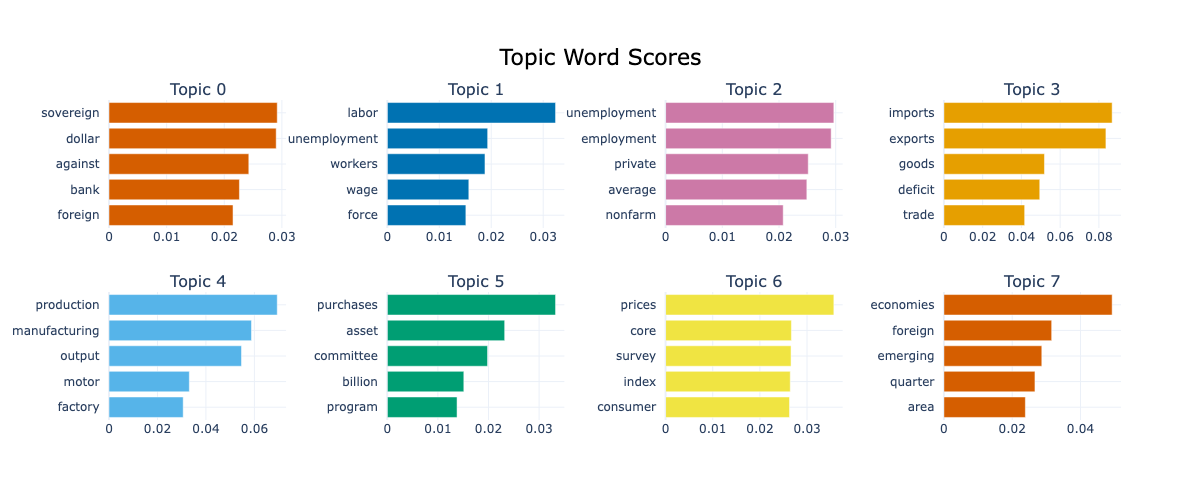

In [20]:
topic_model.visualize_topics()
topic_model.visualize_barchart()


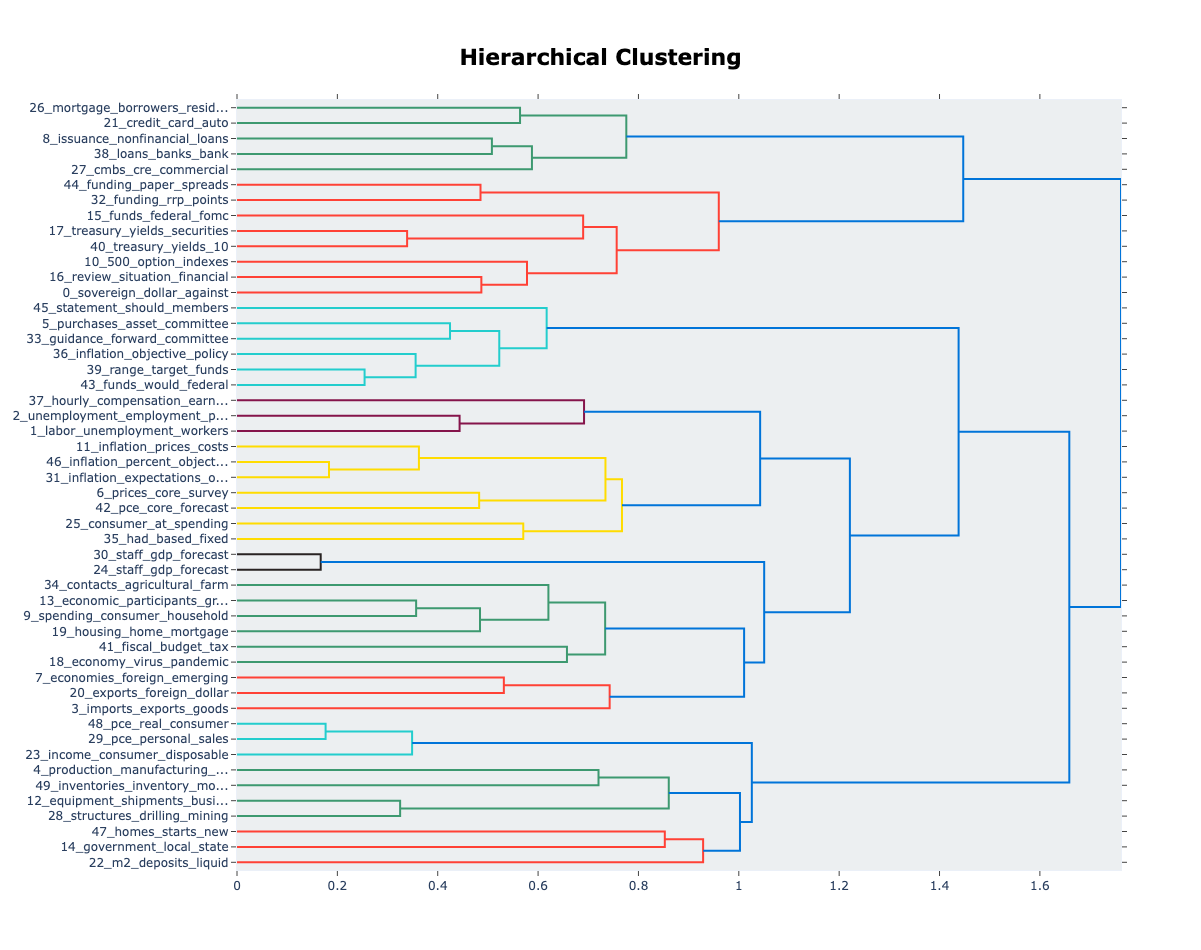

In [21]:
topic_model.visualize_hierarchy(top_n_topics=50)

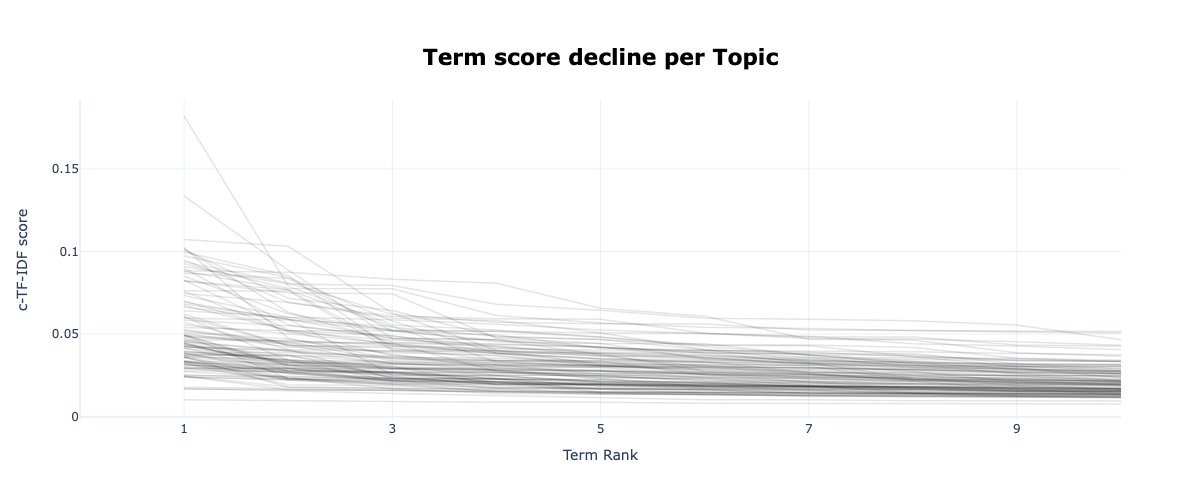

In [22]:
topic_model.visualize_term_rank()

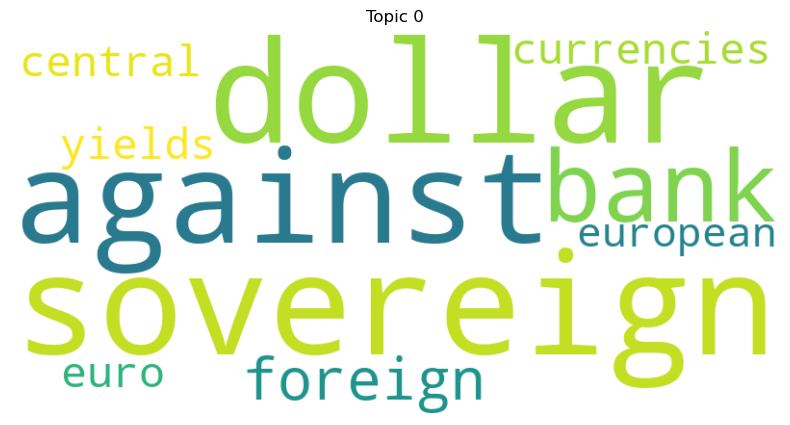

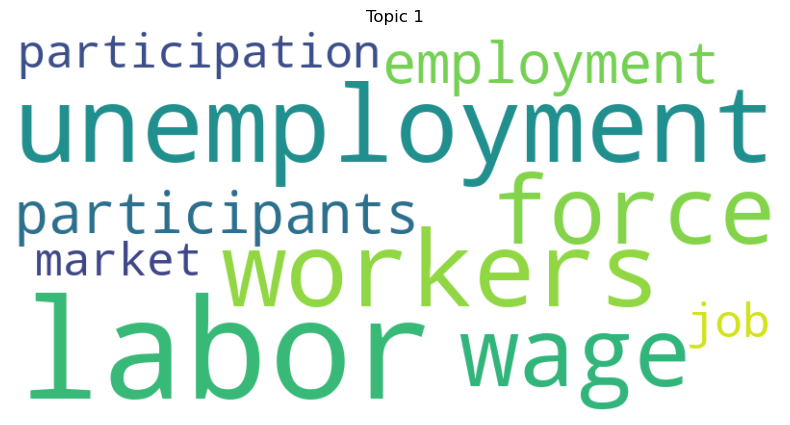

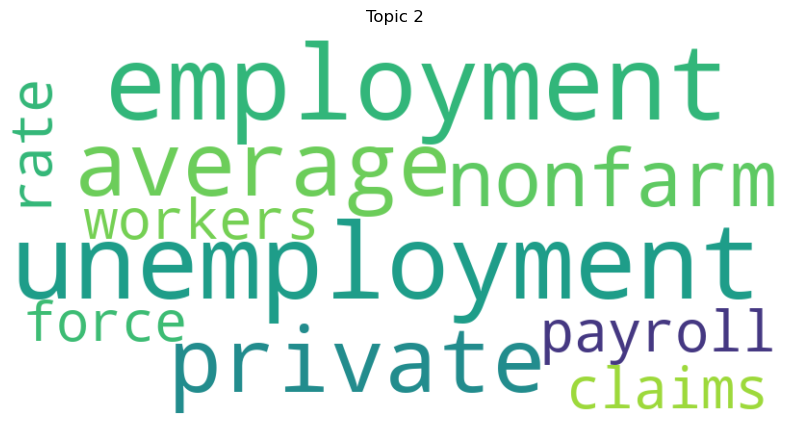

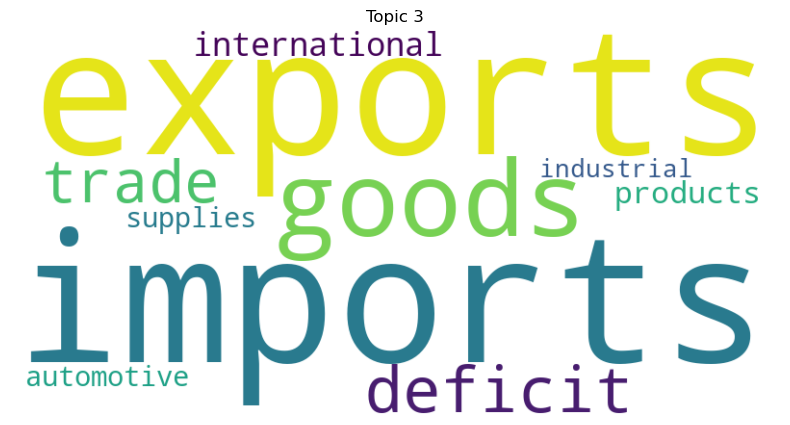

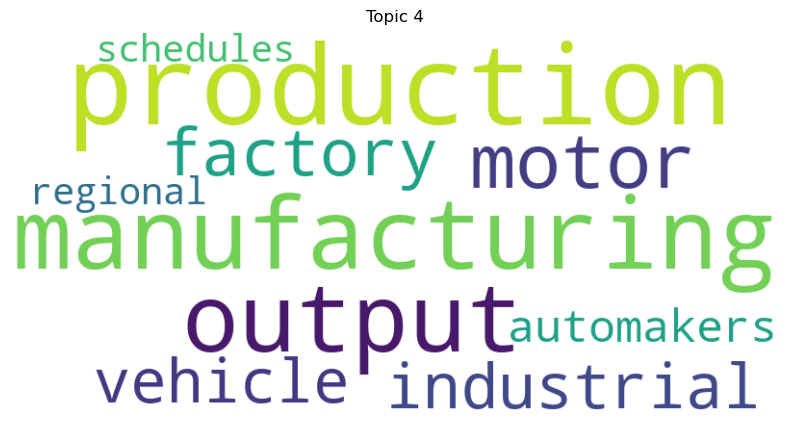

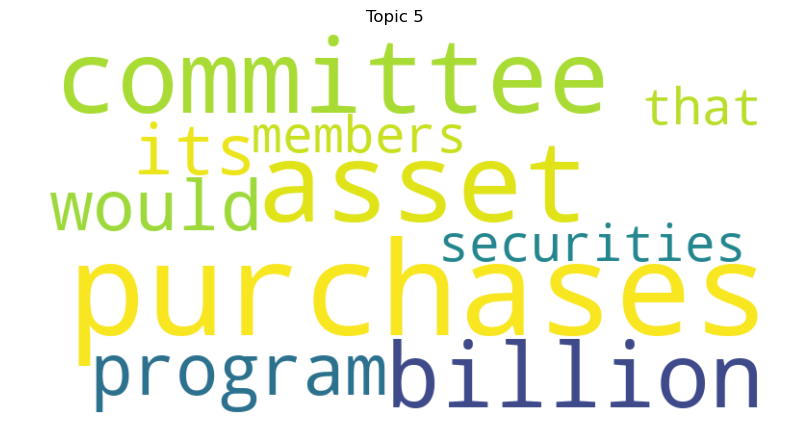

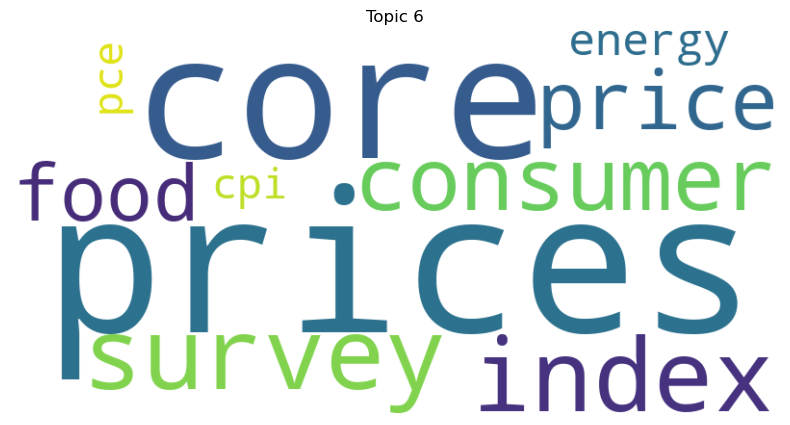

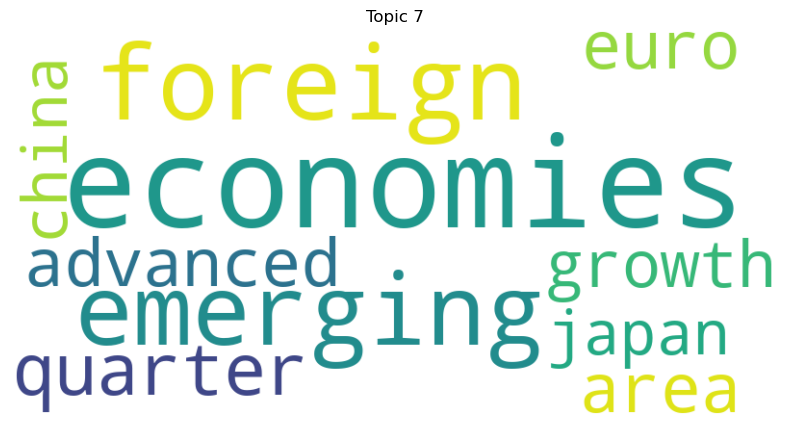

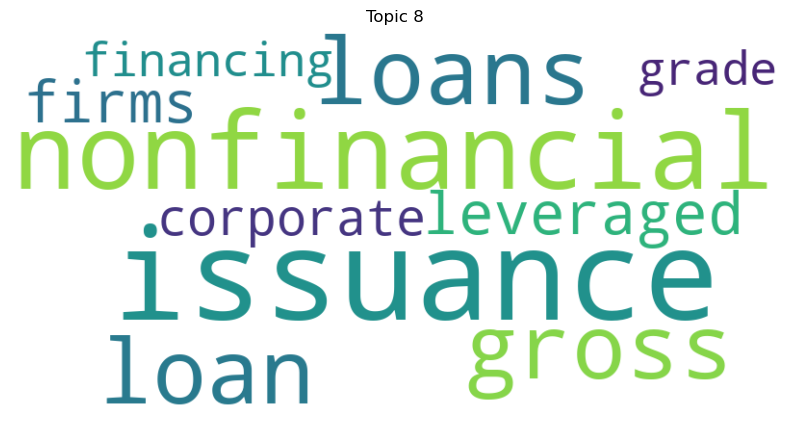

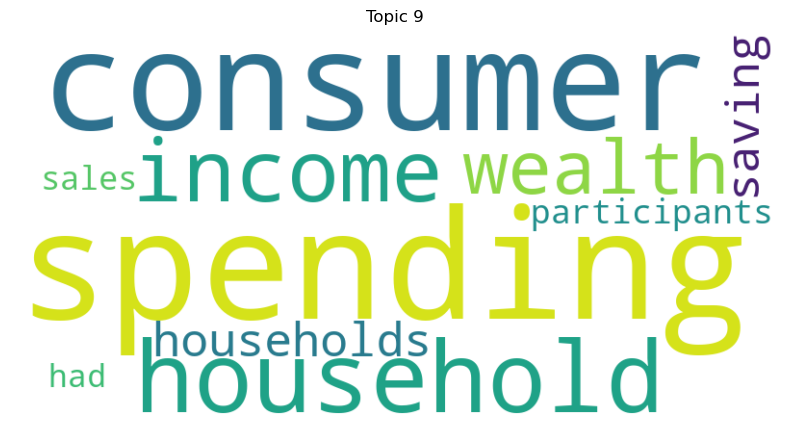

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate a word cloud for one topic
def generate_word_cloud(topic_number, topic_words):
    # Create a dictionary of word frequencies
    word_freq = {word: score for word, score in topic_words}
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_number}')
    plt.show()

# Assuming 'topic_model' is your BERTopic instance
for topic_num in range(10):  # Adjust the range based on how many topics you want to generate word clouds for
    topic_words = topic_model.get_topic(topic_num)
    if topic_words is not None:  # Check if the topic exists
        generate_word_cloud(topic_num, topic_words)
    else:
        print(f"Topic {topic_num} does not exist")


## <a name="finbert"></a>FinBERT with LDA
FinBERT is a pre-trained transformer model, specifically trained for the finance domain. https://github.com/ProsusAI/finBERT. The sentiment scoring component derives from Financial PhraseBank dataset. 
Here we will score each old text instead of our lemmatised 'new text'. 

In [30]:
#Load tokenizer and model
transformer_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
transformer_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert",output_hidden_states=True,output_attentions=False)
 

In [31]:
text = ['Participants','remarked','that','inflation','readings','had','been','higher','and','were','more','persistent','and','widespread','than','previously','anticipated','.']

In [32]:
print(transformer_tokenizer.convert_ids_to_tokens(transformer_tokenizer(paras[0].tokens,padding=True,is_split_into_words=True)['input_ids']))

['[CLS]', 'and', 'the', 'conduct', 'of', 'monetary', 'policy', 'over', 'the', 'inter', '##me', '##eti', '##ng', 'period', '.', '[SEP]']


In [33]:
#How many our of documents get truncated?
plengths = []
for p in paras:
    plengths.append(len(transformer_tokenizer.encode(p.tokens,padding=True,is_split_into_words=True)))

Token indices sequence length is longer than the specified maximum sequence length for this model (545 > 512). Running this sequence through the model will result in indexing errors


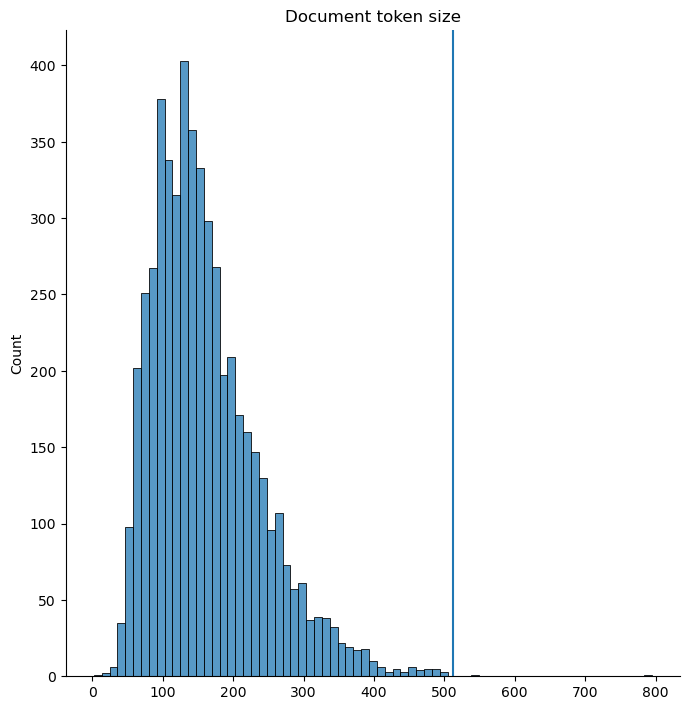

In [34]:

sns.displot(plengths,height=7).set(title='Document token size')
plt.axvline(transformer_tokenizer.model_max_length)

Most documents have tokens less than the maximum model size, which means we don't have to worry about truncation, in fact we could probably truncate our tokens to 350

## Extracting features from latest transcript

In [35]:
file_id = '20211215'
latest_minutes = fed_mins.get_paras(file_id = file_id,flatten=True,stem=True)
tokenizer_settings = dict(is_split_into_words=True,max_length=350,padding='max_length',truncation=True,return_tensors="pt")

document_feat = FeatureProcessor(latest_minutes,
                                transformer_model=transformer_model,
                                transformer_tokenizer=transformer_tokenizer,
                                tokenizer_settings=tokenizer_settings,
                                lda_model=lda_model,
                                lda_vec=vectorizer,
                                lda_topic_dict=topic_dict,batch_size=30)

In [36]:
latest_minutes = document_feat.get_features(sentiment=True,embedding=True,topic=True)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [37]:
def corpus_stats(corpus):
    ids = [(n,f.category_id,f.file_id) for n,f in enumerate(corpus)]
    df_ids = pd.DataFrame(ids,columns=['idx','category_id','file_id'])
    start_idx = df_ids.drop_duplicates(['category_id','file_id'],keep='first')
    end_idx = df_ids.drop_duplicates(['category_id','file_id'],keep='last')

    idx = start_idx.merge(end_idx,on=['category_id','file_id'],suffixes=('_start','_end'))

    stats =[]
    corpus_sent = corpus.extract_features('sentiment')
    corpus_topic = corpus.extract_features('topics')

    for s,cat_id,file_id,e in idx.values:
        net_tone = [s['logits'][0] - s['logits'][1] for s in corpus_sent[s:e]]
        topic_dist = [s['topic_dist'] for s in corpus_topic[s:e]]
        topic_sentiment = np.asarray(topic_dist) * np.asarray(net_tone).reshape(-1,1)
        topic_mean_sent = topic_sentiment.mean(axis=0).tolist()

        stats.append((cat_id,file_id,*topic_mean_sent))
    return stats


latest_stats = corpus_stats(latest_minutes)
latest_stats = pd.DataFrame(latest_stats,columns = ['category_id','file_id']+list(topic_dict.values()))
latest_stats['month'] = pd.to_datetime(latest_stats['file_id']).dt.to_period('M')
latest_stats.set_index(['month'],inplace=True)

<Axes: title={'center': 'Average net-tone per topic for file:20211215'}, xlabel='month'>

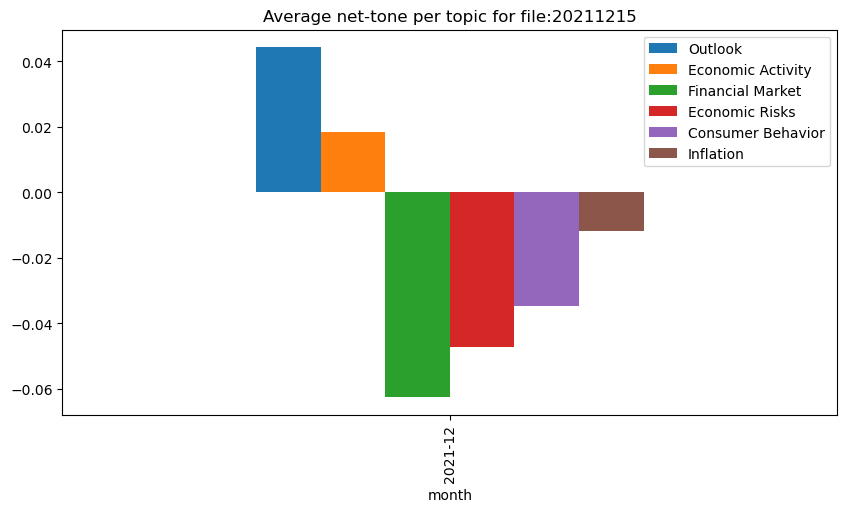

In [38]:
latest_stats.plot(kind='bar',title='Average net-tone per topic for file:{}'.format(file_id),figsize=(10,5))

without context from previous transcript, this doesn't tell us much 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

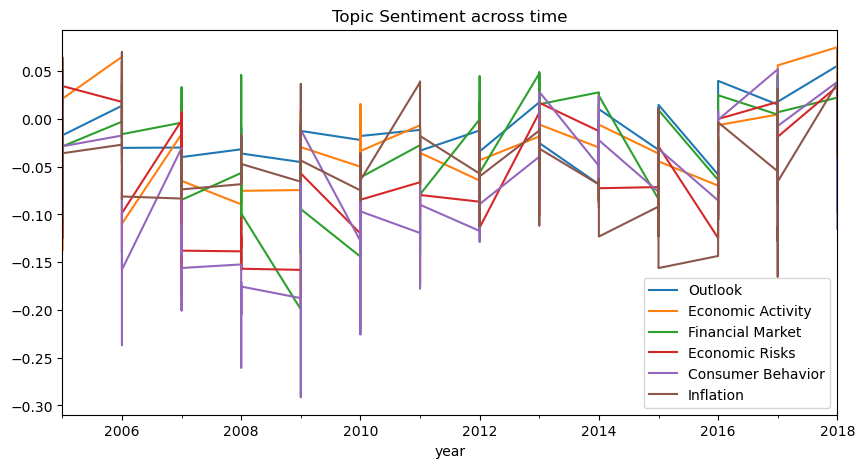

In [39]:
import pandas as pd

# Initialize an empty list to store DataFrames for each year
all_years_stats = []

# Loop through the years from 2005 to 2018
for year in range(2005, 2019):
    # Get the minutes for the current year
    current_year_minutes = fed_mins.get_paras(category_id=str(year), flatten=True, stem=True)
    
    # Process the features for the current year
    document_feat = FeatureProcessor(current_year_minutes,
                                     transformer_model=transformer_model,
                                     transformer_tokenizer=transformer_tokenizer,
                                     tokenizer_settings=tokenizer_settings,
                                     lda_model=lda_model,
                                     lda_vec=vectorizer,
                                     lda_topic_dict=topic_dict,
                                     batch_size=30)
    current_year_features = document_feat.get_features()
    
    # Compute statistics for the current year
    current_year_stats = pd.DataFrame(corpus_stats(current_year_features),
                                      columns=['category_id', 'file_id'] + list(topic_dict.values()))
    
    # Add a 'year' column to the statistics DataFrame
    current_year_stats['year'] = pd.to_datetime(current_year_stats['file_id']).dt.to_period('Y')
    
    # Set the index to 'year' for easier plotting and analysis
    current_year_stats.set_index(['year'], inplace=True)
    
    # Append the statistics DataFrame for the current year to the list
    all_years_stats.append(current_year_stats)

# Concatenate the DataFrames for all years along the rows
all_years_stats = pd.concat(all_years_stats)

# Plot the sentiment across time for all years
all_years_stats[[i for i in all_years_stats.columns if i not in ['category_id', 'file_id']]].plot(kind='line', figsize=(10, 5), title='Topic Sentiment across time')

# Save the statistics to a CSV file
all_years_stats.to_csv('2005-2018_sentiment_by_topic.csv')


In [24]:
### ATTEMPT AT DOING finbert on BERTOPIC!

<Axes: title={'center': 'Average Sentiment by Topic over Time'}, xlabel='year'>

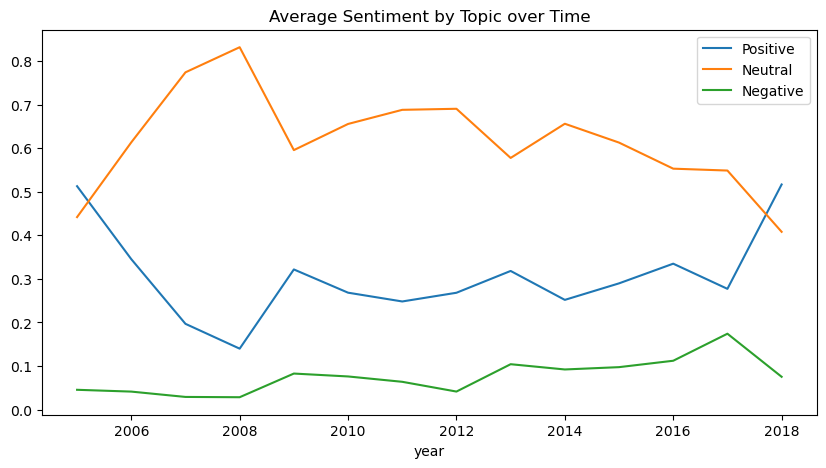

In [29]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from bertopic import BERTopic
from collections import defaultdict

# Assuming fed_mins.get_paras() gives us documents segmented by time
documents_by_time = defaultdict(list)
for year in range(2005, 2019):
    documents_by_time[year] = [" ".join(doc) for doc in fed_mins.get_paras(category_id=str(year), flatten=True, stem=True)]

# Load FinBERT
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

def sentiment_analysis(text):
    """ Perform sentiment analysis using FinBERT """
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return probabilities.numpy().squeeze()  # Ensure output is squeezed to 2D

# Initialize list to store DataFrames for each year
all_years_stats = []

for year, docs in documents_by_time.items():
    topic_model = BERTopic()
    topics, probabilities = topic_model.fit_transform(docs)
    topic_info = topic_model.get_topic_info()  # Get information about each topic
    representative_docs = {topic: topic_model.get_representative_docs(topic) for topic in topic_info['Topic'] if topic != -1}

    sentiments = {}
    for topic, docs in representative_docs.items():
        if topic == -1:  # Skip outliers
            continue
        # Average sentiment for the top representative documents
        topic_sentiments = np.array([sentiment_analysis(doc) for doc in docs])
        average_sentiments = np.mean(topic_sentiments, axis=0)  # Make sure averaging happens on the correct axis
        sentiments[topic] = average_sentiments

    # DataFrame for current year
    df_stats = pd.DataFrame.from_dict(sentiments, orient='index', columns=['Positive', 'Neutral', 'Negative'])
    df_stats['year'] = year
    all_years_stats.append(df_stats)

# Concatenate and visualize
all_years_data = pd.concat(all_years_stats)
all_years_data.groupby('year').mean().plot(kind='line', figsize=(10, 5), title='Average Sentiment by Topic over Time')


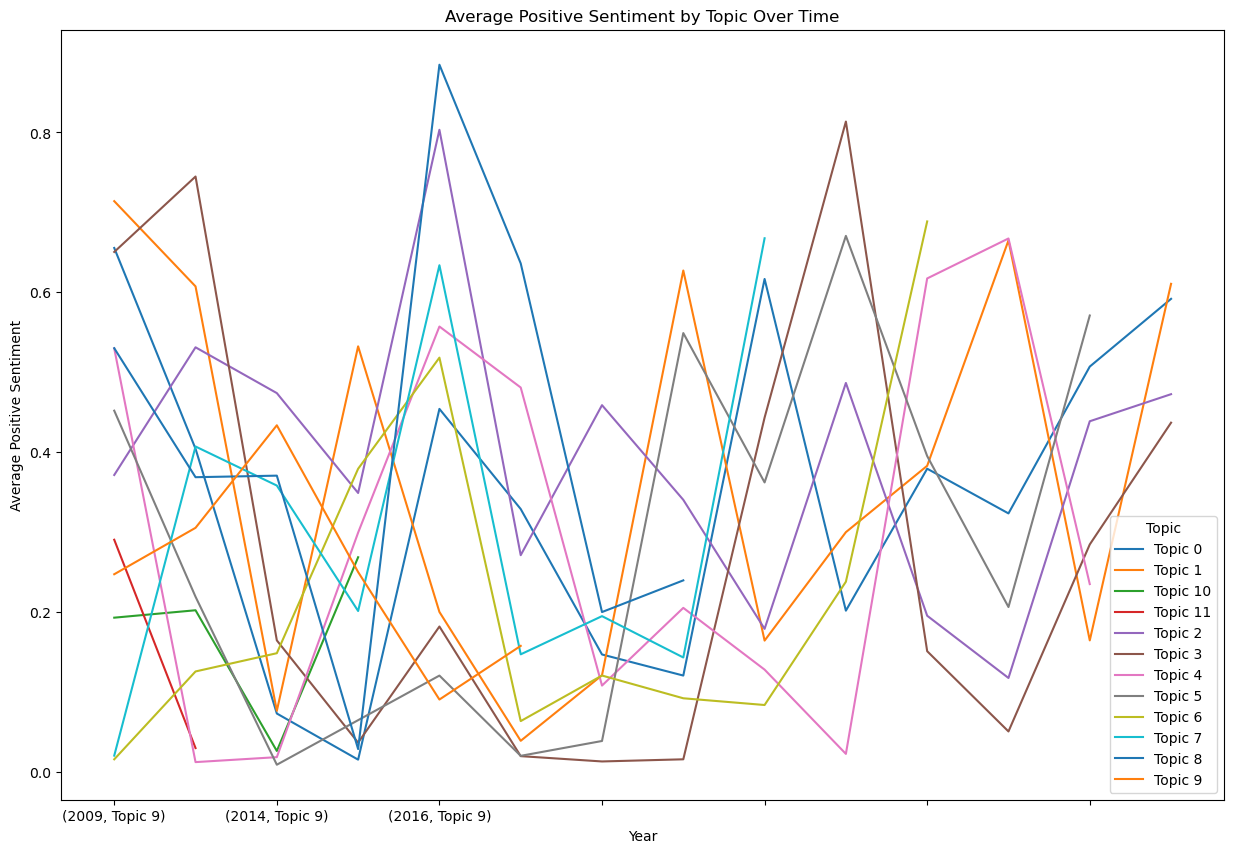

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from bertopic import BERTopic
from collections import defaultdict

# Assuming fed_mins.get_paras() provides documents segmented by time
documents_by_time = defaultdict(list)
for year in range(2005, 2019):
    documents_by_time[year] = [" ".join(doc) for doc in fed_mins.get_paras(category_id=str(year), flatten=True, stem=True)]

# Load FinBERT
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

def sentiment_analysis(text):
    """ Perform sentiment analysis using FinBERT """
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return probabilities.numpy().squeeze()

# Initialize a dictionary to store sentiment data for each topic across years
topic_sentiments_over_time = defaultdict(lambda: defaultdict(list))

for year, docs in documents_by_time.items():
    topic_model = BERTopic()
    topics, probabilities = topic_model.fit_transform(docs)
    topic_info = topic_model.get_topic_info()
    representative_docs = {topic: topic_model.get_representative_docs(topic) for topic in set(topics) if topic != -1}

    for topic, docs in representative_docs.items():
        if topic == -1:
            continue
        # Get sentiment analysis for representative documents
        topic_sentiments = np.array([sentiment_analysis(doc) for doc in docs])
        mean_sentiments = np.mean(topic_sentiments, axis=0)
        topic_sentiments_over_time[topic][year].append(mean_sentiments)

# Prepare DataFrames for plotting
df_list = []
for topic, data in topic_sentiments_over_time.items():
    for year, sentiments in data.items():
        avg_sentiment = np.mean(sentiments, axis=0)
        df = pd.DataFrame(avg_sentiment.reshape(1, -1), columns=['Positive', 'Neutral', 'Negative'])
        df['Year'] = year
        df['Topic'] = f"Topic {topic}"
        df_list.append(df)

df_all = pd.concat(df_list)
df_all.set_index(['Year', 'Topic'], inplace=True)
df_all.sort_index(inplace=True)

# Plotting
fig, ax = plt.subplots(figsize=(15, 10))
for key, grp in df_all.groupby('Topic'):
    grp['Positive'].plot(ax=ax, label=key)
plt.legend(title='Topic')
plt.title('Average Positive Sentiment by Topic Over Time')
plt.xlabel('Year')
plt.ylabel('Average Positive Sentiment')
plt.show()


### SAVE?  later.

In [ ]:
"""
#Save Transformer models
save_path = os.path.join(current_directory,"Model")
if not os.path.exists(save_path):
    os.mkdir(save_path)

    
transformer_model.save_pretrained(os.path.join(save_path,"transformer_model"))
#Save LDA,vectorizer,topic_dictionary
transformer_tokenizer.save_pretrained(os.path.join(save_path,"transformer_tokenizer"))
#save tokenizer settings
pickle.dump(tokenizer_settings,open(os.path.join(save_path,"tokenizer_settings.pkl"),"wb"))

#save lda model

with open(os.path.join(save_path,"lda_models.pkl"),'wb') as models:
    pickle.dump((lda_model,vectorizer,topic_dict),models)

"""
